<a href="https://colab.research.google.com/github/tripsysi/Wine_Classifier/blob/main/DATA7703_Project_Wine_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA7703 Project  - Wine Classifier

In [ ]:
####################
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns

## Read in data

In [ ]:
redwine = pd.read_csv("https://raw.githubusercontent.com/tripsysi/Wine_Classifier/main/data/winequality-red.csv")
whitewine = pd.read_csv("https://raw.githubusercontent.com/tripsysi/Wine_Classifier/main/data/winequality-white.csv")

Citation : Data from https://archive.ics.uci.edu/ml/datasets/wine+quality

In [ ]:
redwine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [ ]:
print(redwine.shape)
print(whitewine.shape)

(1599, 12)
(4898, 12)


## Preprocessing

### Visual EDA ??

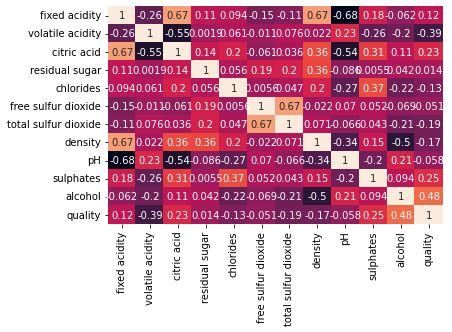

In [ ]:
sns.heatmap(redwine.corr(), annot=True, cbar=False);

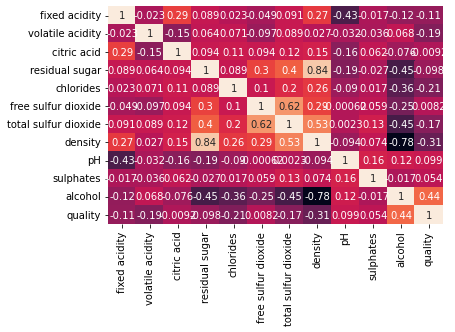

In [ ]:
sns.heatmap(whitewine.corr(), annot=True, cbar=False);

### Merging Wine tables 

In [ ]:
redwine.insert(11, 'Winetype', 0)
whitewine.insert(11, 'Winetype', 1)

In [ ]:
print(redwine.shape)
print(whitewine.shape)

(1599, 13)
(4898, 13)


In [ ]:
wines = pd.concat([redwine,whitewine])
wines.shape

(6497, 13)

In [ ]:
wines.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
Winetype                0
quality                 0
dtype: int64

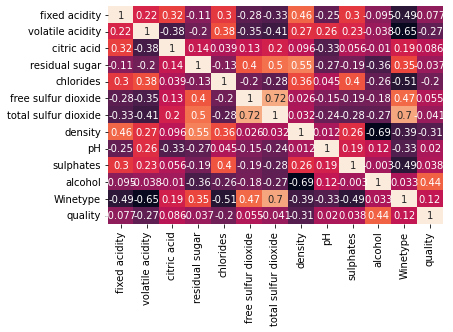

In [ ]:
sns.heatmap(wines.corr(), annot=True, cbar=False);

### Normalizing data

In [ ]:
X = wines.iloc[: , :-1]
y = wines.iloc[:,-1:]

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Splitting into Train Test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)

In [ ]:
X_train.shape #check

(5847, 12)

In [ ]:
X_test.shape

(650, 12)

In [ ]:
y_train.shape

(5847, 1)

In [ ]:
y_test.shape

(650, 1)

## Modelling

### Knn

### Naïve Bayes

### Random Forest